<a href="https://colab.research.google.com/github/Sontam3000/-META_DATA_FEATURE_EXTRACTION-_Stacked_Ensemble0_Multimodal_Pricing_-_Category_Prediction-1-/blob/main/%5BNORMALIZED%5D_MULTIMODAL_PRICING_%26_CATEGORY_PREDICTION_VIA_STACKED_ENSEMBLE_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##[NORMALIZED ONLY] MULTIMODAL PRICING & CATEGORY PREDICTION VIA STACKED ENSEMBLE

####Data: Fashion-MNIST images

####Tasks:

Classification – predict clothing category (10 classes)

Regression – predict a synthetic price you construct from metadata + class signals

Models (Level-0): Logistic Regression, ANN, Tensor Flow Keras Model, XG Boost, CNN

Meta-learner (Level-1): Tensor Flow Dense Model

---


### Hybrid Stacked Model
A hybrid stacked model (or stacked ensemble) blends diverse algorithms—each good at capturing different patterns—by training a meta-model on their predictions.


Level-0 (Base Models)

Logistic Regression: learns linear trends
Decision Tree: learns rules and interactions
ANN (MLP):  learns complex nonlinear patterns	Each model predicts class probabilities independently

Level-1 (Meta-Learner)

Logistic Regression (for classification) or Linear Regression (for price)	Learns how to weight and combine the base models’ predictions for the final output


---


### DATASET STRUCTURE

Dataset type: Image classification

Goal: Predict the type of clothing shown in a grayscale image

Total samples: 70,000 images

Training set: 60,000 images

Test set: 10,000 images

Image size: 28 × 28 pixels

Color: Grayscale (each pixel ∈ [0, 255])

Format: Each image is a 2-D NumPy array (28×28), and each label is an integer (0–9).
---

### DATA LABELS

| Label ID | Class Name  |
| -------- | ----------- |
| 0        | T-shirt/top |
| 1        | Trouser     |
| 2        | Pullover    |
| 3        | Dress       |
| 4        | Coat        |
| 5        | Sandal      |
| 6        | Shirt       |
| 7        | Sneaker     |
| 8        | Bag         |
| 9        | Ankle boot  |



In [ ]:
from tensorflow.keras.datasets import fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


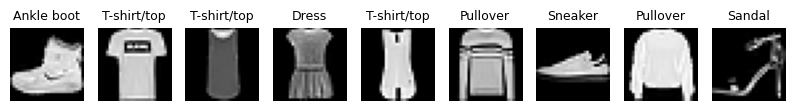

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

SEED = 42
np.random.seed(SEED)
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

fig, axes = plt.subplots(1, len(class_names) - 1, figsize=(10, 2))
for i, ax in enumerate(axes):
    ax.imshow(train_images[i], cmap='gray')
    ax.set_title(class_names[train_labels[i]], fontsize=9)
    ax.axis('off')

plt.show()

In [ ]:
from collections import Counter
cnt = Counter(train_labels)
for i in cnt:
  print(class_names[i], cnt[i])

Ankle boot 6000
T-shirt/top 6000
Dress 6000
Pullover 6000
Sneaker 6000
Sandal 6000
Trouser 6000
Shirt 6000
Coat 6000
Bag 6000


### Data Preprocessing

Prforming normalization only in the dataset.

In [ ]:
train_images = train_images / 255.0
test_images = test_images / 255.0
print(train_images.min())
print(test_images.max())

0.0
1.0


In [ ]:
X_train = train_images.reshape((train_images.shape[0], -1))
X_test = test_images.reshape((test_images.shape[0], -1))

Y_train = train_labels
Y_test  = test_labels

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2, random_state = SEED)

### DATA MODELLING


### K_FOLD VALIDATION CHECK

In [ ]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np

X = X_train  # (60,000, 784)
y = Y_train  # (60,000,)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []

for train_idx, val_idx in kf.split(X):
    X_tr, X_val = X[train_idx], X[val_idx]
    y_tr, y_val = y[train_idx], y[val_idx]

    model = LogisticRegression(max_iter=1000)
    model.fit(X_tr, y_tr)

    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    fold_accuracies.append(acc)

print(f"\nAverage Validation Accuracy: {np.mean(fold_accuracies)*100:.2f}%")



Average Validation Accuracy: 85.05%


### LOGISTIC REGRESSION [MANUAL]

In [ ]:
def softmax(z):
  exp = np.exp(z - np.max(z, axis=0, keepdims=True))
  return exp / np.sum(exp, axis=0, keepdims=True)

In [ ]:
class MyLogisticRegression:
  def __init__(self, num_features, num_classes, learning_rate=0.1):
        self.W = np.zeros((num_classes, num_features))
        self.w_0 = np.zeros((num_classes, 1))
        self.learning_rate = learning_rate

  def fit(self, X, Y, epochs=1000, print_loss= True):
    Y = np.array(Y).astype(int)
    m= X.shape[1]
    losses = []
    for i in range(epochs):
      Z = np.dot(self.W, X) + self.w_0  # Z = W^T * X + w_0
      A = softmax(Z)
      Y_onehot = np.eye(self.W.shape[0])[Y.reshape(-1)].T
      loss =  -np.sum(Y_onehot * np.log(A + 1e-15)) / m  # Cross-entropy loss

      # Compute loss (categorical cross-entropy)
      loss = -np.sum(Y_onehot * np.log(A + 1e-15)) / m
      # Gradients
      dW = (1/m) * np.dot((A - Y_onehot), X.T)
      db = (1/m) * np.sum(A - Y_onehot, axis=1, keepdims=True)

      # Update
      self.W = self.W - self.learning_rate * dW
      self.w_0 = self.w_0 - self.learning_rate * db

      if i % 100 == 0:
          losses.append(loss)
          if print_loss:
              print(f"Epoch {i}: Loss = {loss:.4f}")

    return losses

  def predict(self, X):
    Z_prediction = np.dot(self.W, X) + self.w_0
    A = softmax(Z_prediction)
    return np.argmax(A, axis=0)

In [ ]:
def Run_Experiment(X_train, Y_train, X_val, Y_val, X_test, Y_test,
                   epochs=2000, learning_rate=0.1, print_loss=False):

    # Transpose
    X_train_T = X_train.T
    X_val_T   = X_val.T
    X_test_T  = X_test.T

    num_features = X_train_T.shape[0]
    num_classes  = len(np.unique(Y_train))

    model = MyLogisticRegression(num_features, num_classes, learning_rate)

    losses = model.fit(X_train_T, Y_train, epochs=epochs, print_loss=print_loss)

    Y_pred_val = model.predict(X_val_T)
    val_acc = np.mean(Y_pred_val == Y_val) * 100
    print(f"\nValidation Accuracy: {val_acc:.2f}%")


    Y_pred_test = model.predict(X_test_T)
    test_acc = np.mean(Y_pred_test == Y_test) * 100
    print(f"Final Test Accuracy (after tuning): {test_acc:.2f}%")

    d = {
        "losses": losses,
        "Y_pred_val": Y_pred_val,
        "Y_pred_test": Y_pred_test,
        "W": model.W.tolist(),
        "b": model.w_0.tolist(),
        "learning_rate": learning_rate,
        "epochs": epochs,
        "val_acc": val_acc,
        "test_acc": test_acc
    }

    return d


Epoch 0: Loss = 2.3026
Epoch 100: Loss = 0.7417
Epoch 200: Loss = 0.6421
Epoch 300: Loss = 0.5951
Epoch 400: Loss = 0.5661
Epoch 500: Loss = 0.5458
Epoch 600: Loss = 0.5305
Epoch 700: Loss = 0.5185
Epoch 800: Loss = 0.5087
Epoch 900: Loss = 0.5005
Epoch 1000: Loss = 0.4935
Epoch 1100: Loss = 0.4874
Epoch 1200: Loss = 0.4820
Epoch 1300: Loss = 0.4773
Epoch 1400: Loss = 0.4730
Epoch 1500: Loss = 0.4691
Epoch 1600: Loss = 0.4656
Epoch 1700: Loss = 0.4624
Epoch 1800: Loss = 0.4594
Epoch 1900: Loss = 0.4566
Epoch 2000: Loss = 0.4541
Epoch 2100: Loss = 0.4517
Epoch 2200: Loss = 0.4495
Epoch 2300: Loss = 0.4474
Epoch 2400: Loss = 0.4454
Epoch 2500: Loss = 0.4436
Epoch 2600: Loss = 0.4418
Epoch 2700: Loss = 0.4401
Epoch 2800: Loss = 0.4386
Epoch 2900: Loss = 0.4371

Validation Accuracy: 84.41%
Final Test Accuracy (after tuning): 83.50%


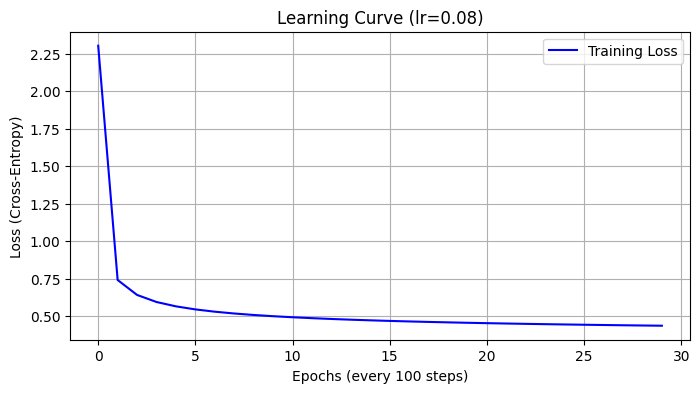

Validation Accuracy: 84.41%
Final Test Accuracy: 83.50%


In [ ]:
X_train = train_images.reshape((train_images.shape[0], -1))
Y_train = train_labels

X_test = test_images.reshape((test_images.shape[0], -1))
Y_test = test_labels

from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2, random_state = SEED)

d = Run_Experiment(X_train, Y_train, X_val,
                   Y_val, X_test, Y_test,
                   epochs = 3000, learning_rate = 0.08, print_loss = True)
# Plot learning curve (with costs)
losses = np.squeeze(d["losses"])
plt.figure(figsize=(8,4))
plt.plot(losses, color='blue', label='Training Loss')
plt.ylabel("Loss (Cross-Entropy)")
plt.xlabel("Epochs (every 100 steps)")
plt.title(f"Learning Curve (lr={d['learning_rate']})")
plt.legend()
plt.grid(True)
plt.show()

# Print accuracies
print(f"Validation Accuracy: {d['val_acc']:.2f}%")
print(f"Final Test Accuracy: {d['test_acc']:.2f}%")

#### PREDICTION ON RANDOM DATA

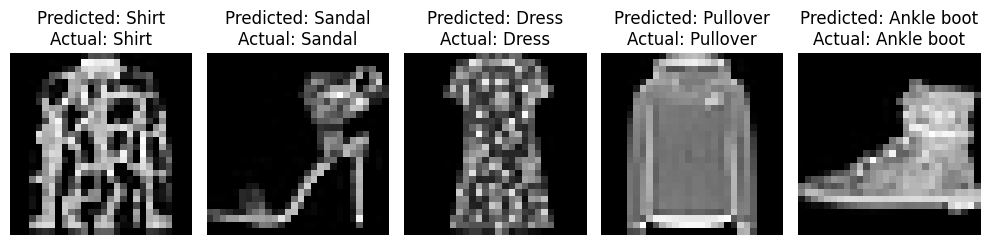

In [ ]:
import matplotlib.pyplot as plt
import random

random_five_idx = random.sample(range(len(X_test)), 5)
plt.figure(figsize=(10, 4))

for i, idx in enumerate(random_five_idx):
  plt.subplot(1,5, i+1)
  img = X_test[idx].reshape(28, 28)
  plt.imshow(img, cmap='gray')
  plt.title(f"Predicted: {class_names[d['Y_pred_test'][idx]]}\nActual: {class_names[Y_test[idx]]}")
  plt.axis('off')
plt.tight_layout()
plt.show()

### LOGISTIC REGRESSION [SCIKIT LEARN]

In [ ]:
final_model = LogisticRegression(max_iter=1000)
final_model.fit(X_train, Y_train)

y_pred_val = final_model.predict(X_val)
y_pred_test = final_model.predict(X_test)

val_acc = accuracy_score(Y_val, y_pred_val)*100
test_acc = accuracy_score(Y_test, y_pred_test)*100

print(f"Validation Accuracy: {val_acc:.2f}%")
print(f"Test Accuracy: {test_acc:.2f}%")

Validation Accuracy: 85.09%
Test Accuracy: 84.10%


#### PREDICITON ON RANDOM DATA

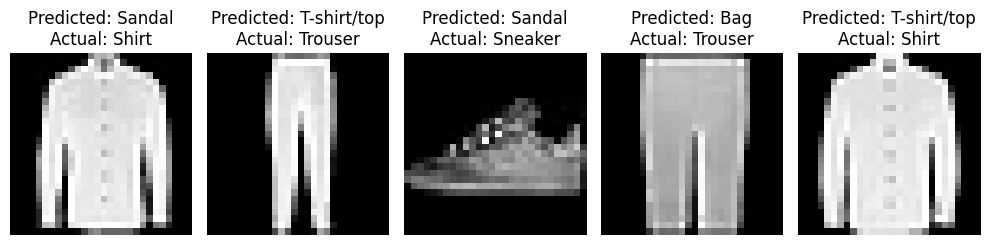

In [ ]:
import matplotlib.pyplot as plt
import random

random_five_idx = random.sample(range(len(X_test)), 5)
plt.figure(figsize=(10, 4))
for i, idx in enumerate(random_five_idx):
  plt.subplot(1,5, i+1)
  img = X_test[idx].reshape(28, 28)
  plt.imshow(img, cmap='gray')
  plt.title(f"Predicted: {class_names[y_pred[idx]]}\nActual: {class_names[Y_test[idx]]}")
  plt.axis('off')
plt.tight_layout()
plt.show()

### ARTIFICIAL NEURAL NETWORK [MANUAL] ACTIVATION DUNCTION : LEAKY RELU

In [ ]:
import cupy as cp
def softmax(z):
  exp_x = cp.exp(z - cp.max(z, axis=0, keepdims=True))
  return exp_x / cp.sum(exp_x, axis=0, keepdims=True)

In [ ]:
class My_Artificial_NN:
  def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01, eta=0):
    cp.random.seed(42)
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.learning_rate = learning_rate
    self.eta = eta

    self.W1 = cp.random.randn(self.hidden_size, self.input_size)* cp.sqrt(2. /self.input_size)
    self.b1 = cp.zeros((self.hidden_size, 1))
    self.W2 = cp.random.randn(self.output_size, self.hidden_size)*cp.sqrt(2. /self.input_size)
    self.b2 = cp.zeros((self.output_size, 1))

    assert(self.W1.shape == (self.hidden_size, self.input_size))
    assert(self.b1.shape == (self.hidden_size, 1))
    assert(self.W2.shape == (self.output_size, self.hidden_size))
    assert(self.b2.shape == (self.output_size, 1))

  def forward_propagation(self, X):
    Z1 = cp.dot(self.W1, X) + self.b1
    A1 = cp.where(Z1 > 0, Z1, self.eta*Z1)
    Z2 = cp.dot(self.W2, A1) + self.b2
    A2 = softmax(Z2)

    m = X.shape[1]
    assert(A1.shape == (self.hidden_size, m))
    assert(A2.shape == (self.output_size, m))

    cache={
        "Z1": Z1,
        "A1": A1,
        "Z2": Z2,
        "A2": A2
    }

    return A2, cache

  def compute_loss(self, Y_onehot, A2):
      m = Y_onehot.shape[1]
      return -cp.sum(Y_onehot * cp.log(A2 + 1e-15)) / m

  def back_propagation(self, X, Y_onehot, cache):
    m = Y_onehot.shape[1]

    A1 = cache["A1"]
    A2 = cache["A2"]
    Z1 = cache["Z1"]
    Z2 = cache["Z2"]

    dZ2 = A2 - Y_onehot
    dW2 = (1/m) * cp.dot(dZ2, A1.T)
    db2 = (1/m) * cp.sum(dZ2, axis=1, keepdims=True)
    dA1 = cp.dot(self.W2.T, dZ2)
    dZ1 = dA1 * cp.where(Z1 > 0, 1, self.eta)
    dW1 = (1/m) * cp.dot(dZ1, X.T)
    db1 = (1/m) * cp.sum(dZ1, axis=1, keepdims=True)

    assert dZ2.shape == (self.output_size, m), "Matrix shape incorrect: dZ2"
    assert dW2.shape == (self.output_size, self.hidden_size), "Matrix shape incorrect: dW2"
    assert db2.shape == (self.output_size, 1), "Vector shape incorrect: db2"
    assert dZ1.shape == (self.hidden_size, m), "Matrix shape incorrect: dZ1"
    assert dW1.shape == (self.hidden_size, self.input_size), "Matrix shape incorrect: dW1"
    assert db1.shape == (self.hidden_size, 1), "Vector shape incorrect: db1"


    grads = {"dW1": dW1,
            "db1": db1,
            "dW2": dW2,
            "db2": db2}

    return grads

  def update_parameters(self, grads):
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]

    self.W1 = self.W1 - self.learning_rate * dW1
    self.b1 = self.b1 - self.learning_rate * db1
    self.W2 = self.W2 - self.learning_rate * dW2
    self.b2 = self.b2 - self.learning_rate * db2


  def fit(self, X, Y, epochs=2000, print_loss=True):
    X = cp.asarray(X.T)
    Y = cp.asarray(Y)
    m = X.shape[1]
    Y_onehot = cp.eye(self.output_size)[Y.astype(int)].T
    losses = []

    for i in range(0, epochs):
        A2, cache = self.forward_propagation(X)

        # Loss function. Inputs: "A2, Y, parameters". Outputs: "loss".
        loss = self.compute_loss(Y_onehot, A2)

        # Backpropagation. Inputs: "cache, X, Y". Outputs: "grads".
        grads = self.back_propagation(X, Y_onehot, cache)

        # Last step: Gradient descent parameter update. Inputs: " grads".
        self.update_parameters(grads)
        # Print the cost every 100 iterations
        if print_loss and i % 100 == 0:
            losses.append(cp.asnumpy(loss))
            print ("Loss after iteration %i: %f" %(i, loss))

    return losses

  def predict(self, X):
    X = cp.asarray(X.T) # Transpose X for prediction
    A2, cache = self.forward_propagation(X)
    predictions = cp.argmax(A2, axis=0)
    return cp.asnumpy(predictions)

  def predict_proba(self, X):
    X_cp = cp.asarray(X.T)
    A2_cp, _ = self.forward_propagation(X_cp)
    return cp.asnumpy(A2_cp).T

  def get_parameters(self):
    parameters = {
        "W1": self.W1,
        "b1": self.b1,
        "W2": self.W2,
        "b2": self.b2
    }
    return parameters

Loss after iteration 0: 2.408451
Loss after iteration 100: 0.696828
Loss after iteration 200: 0.581603
Loss after iteration 300: 0.523667
Loss after iteration 400: 0.498674
Loss after iteration 500: 0.472518
Loss after iteration 600: 0.458449
Loss after iteration 700: 0.443100
Loss after iteration 800: 0.439608
Loss after iteration 900: 0.422777
Loss after iteration 1000: 0.412901
Loss after iteration 1100: 0.405411
Loss after iteration 1200: 0.399567
Loss after iteration 1300: 0.399990
Loss after iteration 1400: 0.387211
Loss after iteration 1500: 0.389436
Loss after iteration 1600: 0.378108
Loss after iteration 1700: 0.381617
Loss after iteration 1800: 0.367580
Loss after iteration 1900: 0.368400
Loss after iteration 2000: 0.360661
Loss after iteration 2100: 0.355146
Loss after iteration 2200: 0.350547
Loss after iteration 2300: 0.345910
Loss after iteration 2400: 0.343178
Loss after iteration 2500: 0.340129
Loss after iteration 2600: 0.337072
Loss after iteration 2700: 0.335063
Loss

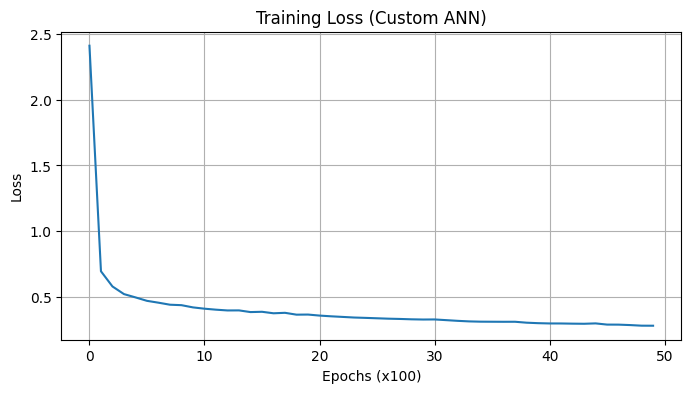

In [ ]:
nn = My_Artificial_NN(input_size=X_train.shape[1], hidden_size=256, output_size=10,
                      learning_rate=0.1, eta=0.1)
losses = nn.fit(X_train, Y_train, epochs=5000,
                print_loss=True,)

# Evaluate
y_pred_val = nn.predict(X_val)
y_pred_test = nn.predict(X_test)

val_acc = cp.mean(y_pred_val == Y_val) * 100
test_acc = cp.mean(y_pred_test == Y_test) * 100

print(f"\nValidation Accuracy: {val_acc:.2f}%")
print(f"Test Accuracy: {test_acc:.2f}%")

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(losses)
plt.title("Training Loss (Custom ANN)")
plt.xlabel("Epochs (x100)")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

#### PREDICITON ON RANDOM DATA


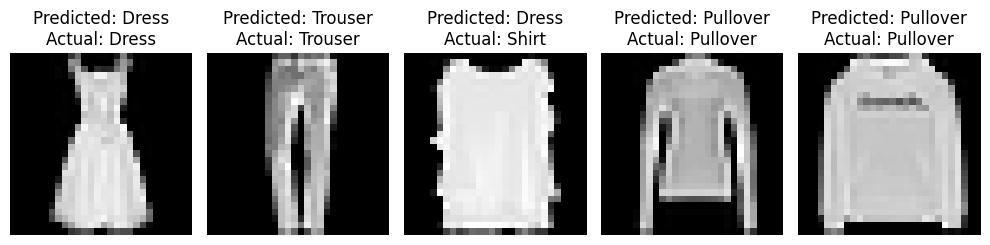

In [ ]:
random_five_idx = random.sample(range(len(X_test)), 5)
plt.figure(figsize=(10, 4))

for i, idx in enumerate(random_five_idx):
  plt.subplot(1,5, i+1)
  img = X_test[idx].reshape(28, 28)
  plt.imshow(img, cmap='gray')
  plt.title(f"Predicted: {class_names[y_pred_test[idx]]}\nActual: {class_names[Y_test[idx]]}")
  plt.axis('off')
plt.tight_layout()
plt.show()

### ARTIFICIAL NEURAL NETWORK [TENSOR FLOW KERAS MODEL]  

In [ ]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU

model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128),
    LeakyReLU(negative_slope=0.01),
    Dense(64),
    LeakyReLU(negative_slope=0.01),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, Y_train, epochs=300, validation_data=(X_val, Y_val))

val_loss, val_acc = model.evaluate(X_val, Y_val, verbose=0)
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=0)


print(f"\nValidation Accuracy: {val_acc * 100:.2f}%")
print(f"\nTest Accuracy: {test_acc * 100:.2f}%")

Epoch 1/300
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7719 - loss: 0.6630 - val_accuracy: 0.8418 - val_loss: 0.4351
Epoch 2/300
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8598 - loss: 0.3865 - val_accuracy: 0.8695 - val_loss: 0.3625
Epoch 3/300
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8752 - loss: 0.3429 - val_accuracy: 0.8684 - val_loss: 0.3731
Epoch 4/300
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8802 - loss: 0.3234 - val_accuracy: 0.8771 - val_loss: 0.3349
Epoch 5/300
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8891 - loss: 0.2967 - val_accuracy: 0.8781 - val_loss: 0.3365
Epoch 6/300
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8950 - loss: 0.2824 - val_accuracy: 0.8775 - val_loss: 0.3404
Epoch 7/300
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9000 - loss: 0.2671 - val_accuracy: 0.8825 - val_loss: 0.3222
Epoch 8/300
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9033 - loss: 0

####PREDICTION USING ANN [TENSOR FLOW KERAS MODEL]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


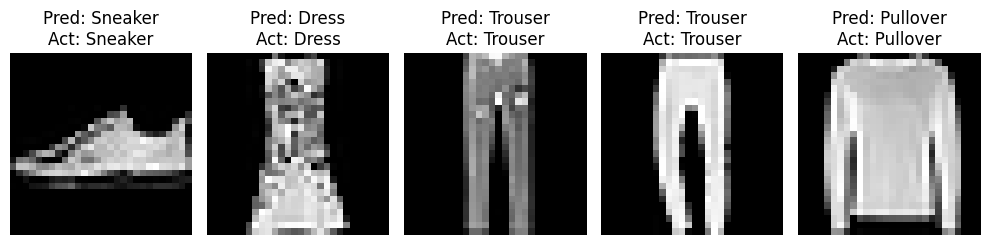

In [ ]:
y_pred_test_prob = model.predict(X_test)
y_pred_test = np.argmax(y_pred_test_prob, axis=1)

random_five_idx = random.sample(range(len(X_test)), 5)

plt.figure(figsize=(10, 4))
for i, idx in enumerate(random_five_idx):
    plt.subplot(1, 5, i+1)
    img = X_test[idx].reshape(28, 28)
    plt.imshow(img, cmap='gray')

    plt.title(f"Pred: {class_names[y_pred_test[idx]]}\nAct: {class_names[Y_test[idx]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

### X GRADIENT BOOST

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

xgb = XGBClassifier(
    objective="multi:softprob",
    num_class=10,
    tree_method="hist",
    eval_metric="mlogloss",
    learning_rate=0.07,
    max_depth=4,
    min_child_weight=2,
    subsample=0.8,
    colsample_bytree=0.9,
    reg_lambda=2.0,
    reg_alpha=0.1,
    n_estimators=1000,
    random_state=42
)

xgb.fit(
    X_train, Y_train,
    eval_set=[(X_val, Y_val)],
    verbose=False
)

y_pred = xgb.predict(X_test)
print("Test acc (baseline):", accuracy_score(Y_test, y_pred)*100)


Test acc (baseline): 89.85


### PREDICTION ON DATA

In [ ]:
print(np.unique(train_labels))
print(np.unique(test_labels))
print(train_labels[:20])
print(test_labels[:20])
print(train_labels.dtype)


[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]
[9 0 0 3 0 2 7 2 5 5 0 9 5 5 7 9 1 0 6 4]
[9 2 1 1 6 1 4 6 5 7 4 5 7 3 4 1 2 4 8 0]
uint8


### CONVOLUTION NEURAL NETWORK (CNN)

In [ ]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images = train_images / 255.0
test_images  = test_images / 255.0
train_images = train_images.reshape(-1, 28, 28, 1)
test_images  = test_images.reshape(-1, 28, 28, 1)

X_train_cnn, X_val_cnn, Y_train_cnn, Y_val_cnn = train_test_split(
    train_images, train_labels,
    test_size=0.2,
    random_state=42
)

X_test_cnn = test_images
Y_test_cnn = test_labels

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model_cnn = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(28,28,1)),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')
])

model_cnn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_cnn.fit(
    X_train_cnn, Y_train_cnn,
    epochs=20,
    validation_data=(X_val_cnn, Y_val_cnn)
)

val_loss, val_acc = model_cnn.evaluate(X_val_cnn, Y_val_cnn)
test_loss, test_acc = model_cnn.evaluate(X_test_cnn, Y_test_cnn)

print("Val Acc:", val_acc*100)
print("Test Acc:", test_acc*100)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.4014 - loss: 1.5776 - val_accuracy: 0.7452 - val_loss: 0.6707
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7341 - loss: 0.7155 - val_accuracy: 0.7702 - val_loss: 0.6001
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7516 - loss: 0.6613 - val_accuracy: 0.7788 - val_loss: 0.5937
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7703 - loss: 0.6243 - val_accuracy: 0.8009 - val_loss: 0.5301
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7827 - loss: 0.5891 - val_accuracy: 0.8082 - val_loss: 0.5105
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7887 - loss: 0.5625 - val_accuracy: 0.8163 - val_loss: 0.4981
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7958 - loss: 0.5571 - val_accuracy: 0.8204 - val_loss: 0.4885
Epoch 8/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8063 - loss: 0.5252 - 

### META LEARNER LEVEL 1

In [ ]:
import tensorflow as tf

P_logreg_val = tf.constant(final_model.predict_proba(X_val), dtype=tf.float32)
P_ann_val    = tf.constant(nn.predict_proba(X_val), dtype=tf.float32)
P_keras_val  = tf.constant(model.predict(X_val), dtype=tf.float32)
P_xgb_val    = tf.constant(xgb.predict_proba(X_val), dtype=tf.float32)
P_cnn_val    = tf.constant(model_cnn.predict(X_val_cnn), dtype=tf.float32)

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [ ]:
meta_X_val = tf.concat([
    P_logreg_val,
    P_ann_val,
    P_keras_val,
    P_xgb_val,
    P_cnn_val
], axis=1)

meta_y_val = tf.constant(Y_val, dtype=tf.int32)

In [ ]:
meta_model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

meta_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

meta_model.fit(
    meta_X_val, meta_y_val,
    epochs=20,
    batch_size=64,
    verbose=1
)

Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6298 - loss: 1.6907
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9065 - loss: 0.3773
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9037 - loss: 0.3097
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9031 - loss: 0.3078
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9108 - loss: 0.2773
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9058 - loss: 0.2924
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9108 - loss: 0.2793
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9096 - loss: 0.2828
Epoch 9/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9062 - loss: 0.2861
Epoch 10/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9138 - loss: 0.2680
Epoch 11/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9165 - loss: 0.2584
Epoch 12/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

In [ ]:
P_logreg_test = tf.constant(final_model.predict_proba(X_test), dtype=tf.float32)
P_ann_test    = tf.constant(nn.predict_proba(X_test), dtype=tf.float32)
P_keras_test  = tf.constant(model.predict(X_test), dtype=tf.float32)
P_xgb_test    = tf.constant(xgb.predict_proba(X_test), dtype=tf.float32)
P_cnn_test    = tf.constant(model_cnn.predict(X_test_cnn), dtype=tf.float32)

meta_X_test = tf.concat([
    P_logreg_test,
    P_ann_test,
    P_keras_test,
    P_xgb_test,
    P_cnn_test
], axis=1)

final_preds = tf.argmax(meta_model.predict(meta_X_test), axis=1)
test_accuracy = tf.reduce_mean(tf.cast(final_preds == tf.constant(Y_test, dtype=tf.int64), tf.float32))
print("Final Stacked Accuracy:", float(test_accuracy) * 100, "%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Final Stacked Accuracy: 90.43999910354614 %
